In [14]:
import os
import numpy as np
# import efficientnet.tfkeras

from vit_keras import vit, utils
from tensorflow.keras.models import load_model
# validation
import pandas as pd

In [15]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


2023-03-13 10:31:39.115285: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-13 10:31:39.115304: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: tiny-photogram
2023-03-13 10:31:39.115307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: tiny-photogram
2023-03-13 10:31:39.115357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.161.3
2023-03-13 10:31:39.115370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.161.3
2023-03-13 10:31:39.115372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.161.3


## load model

In [4]:
#load model  #ValueError: Unknown layer: 'Custom>ClassToken'
from tensorflow.keras.models import load_model

model_dir ='/media/data/ModelVit/Regression/tensorflow/Exp-1/R1/models/modelRegress_ViT_l32_Rheology_R1.h5'
model = load_model(model_dir)
model
# height = width = model.input_shape[1]
# # model = tf.keras.models.load_model(
# #     model_dir,
# #     custom_objects={'Custom>ClassToken':tf.keras.models.Model, 'Custom>AddPositionEmbs':tf.keras.models.Model})
# # model.summary()
# print(f"height: {height}, width: {width}")

2023-03-13 10:31:44.045543: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
model.summary()

Model: "visionregress_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-l32 (Functional)        (None, 1024)              305510400 
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 64)  

## Evaluation model

In [6]:
###** Test set

dataframe = pd.read_csv('/home/kannika/CSV/MSDT_datatest.csv')
print(dataframe.shape)
dataframe.head(5)

(870, 9)


,Unnamed: 0.1,Unnamed: 0,GLY,folderName,fileName,pathimg,idt,MSDT,subset
0,0,0,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/data/Glycerol_FFT_test/GLY10/GLY10P100_...,158,5.63,test
1,1,1,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/data/Glycerol_FFT_test/GLY10/GLY10P100_...,25,0.84,test
2,2,2,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/data/Glycerol_FFT_test/GLY10/GLY10P100_...,7,0.25,test
3,3,3,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/data/Glycerol_FFT_test/GLY10/GLY10P100_...,125,4.45,test
4,4,4,GLY10,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204,GLY10P100_D0_30HZ_20XINF_UWELL_20221230_072204...,/media/data/Glycerol_FFT_test/GLY10/GLY10P100_...,19,0.63,test


In [8]:
height = width = model.input_shape[1]
print(f"height: {height}, width: {width}")

BATCH_SIZE = 16

height: 224, width: 224


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

valid_datagen = ImageDataGenerator(rescale=1./255)

val_generator = valid_datagen.flow_from_dataframe(
                dataframe = dataframe,
                directory = None,
                x_col = 'pathimg',
                y_col = 'MSDT',
                target_size = (height, width),
                batch_size=BATCH_SIZE,
                color_mode= 'rgb',
                class_mode='raw')

Found 870 validated image filenames.


In [13]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])
    
    return result[0]

#Predict
pred_list = list()
#prob_list = list()
img_path=dataframe['pathimg'].tolist()
for i in range(0,len(img_path)):
    predict = predict_image(img_path[i])
    pred_list.append(predict)
    print(predict)

1/1 [==============================] - 0s 119ms/step
[7.8783617]
1/1 [==============================] - 0s 121ms/step
[0.51902395]
1/1 [==============================] - 0s 120ms/step
[0.26609224]
1/1 [==============================] - 0s 120ms/step
[6.268558]
1/1 [==============================] - 0s 118ms/step
[0.42514095]
1/1 [==============================] - 0s 119ms/step
[2.3282666]
1/1 [==============================] - 0s 119ms/step
[22.510555]
1/1 [==============================] - 0s 117ms/step
[33.62011]
1/1 [==============================] - 0s 120ms/step
[61.83906]
1/1 [==============================] - 0s 120ms/step
[0.14934084]
1/1 [==============================] - 0s 120ms/step
[24.023872]
1/1 [==============================] - 0s 118ms/step
[1.4724703]
1/1 [==============================] - 0s 118ms/step
[13.964749]
1/1 [==============================] - 0s 120ms/step
[0.46746904]
1/1 [==============================] - 0s 119ms/step
[0.67285216]
1/1 [=================

1/1 [==============================] - 0s 117ms/step
[0.9113643]
1/1 [==============================] - 0s 120ms/step
[0.76079905]
1/1 [==============================] - 0s 119ms/step
[0.35030025]
1/1 [==============================] - 0s 119ms/step
[11.546949]
1/1 [==============================] - 0s 119ms/step
[0.7652948]
1/1 [==============================] - 0s 119ms/step
[7.34916]
1/1 [==============================] - 0s 119ms/step
[0.31237766]
1/1 [==============================] - 0s 118ms/step
[17.372274]
1/1 [==============================] - 0s 117ms/step
[4.9950647]
1/1 [==============================] - 0s 119ms/step
[18.66643]
1/1 [==============================] - 0s 119ms/step
[1.0355009]
1/1 [==============================] - 0s 117ms/step
[0.47236127]
1/1 [==============================] - 0s 117ms/step
[0.45936075]
1/1 [==============================] - 0s 119ms/step
[36.277023]
1/1 [==============================] - 0s 119ms/step
[0.17424868]
1/1 [=================

1/1 [==============================] - 0s 119ms/step
[0.8399179]
1/1 [==============================] - 0s 119ms/step
[2.9846268]
1/1 [==============================] - 0s 119ms/step
[0.32385996]
1/1 [==============================] - 0s 118ms/step
[0.21361725]
1/1 [==============================] - 0s 120ms/step
[1.1750075]
1/1 [==============================] - 0s 119ms/step
[8.645302]
1/1 [==============================] - 0s 119ms/step
[14.587053]
1/1 [==============================] - 0s 119ms/step
[0.09428737]
1/1 [==============================] - 0s 119ms/step
[0.6529059]
1/1 [==============================] - 0s 119ms/step
[0.95917344]
1/1 [==============================] - 0s 118ms/step
[4.4184384]
1/1 [==============================] - 0s 117ms/step
[0.3229095]
1/1 [==============================] - 0s 120ms/step
[2.1766298]
1/1 [==============================] - 0s 121ms/step
[0.63642764]
1/1 [==============================] - 0s 119ms/step
[0.21911596]
1/1 [===============

1/1 [==============================] - 0s 119ms/step
[1.7789679]
1/1 [==============================] - 0s 119ms/step
[3.9788535]
1/1 [==============================] - 0s 118ms/step
[0.15400566]
1/1 [==============================] - 0s 119ms/step
[30.118137]
1/1 [==============================] - 0s 118ms/step
[0.32168806]
1/1 [==============================] - 0s 118ms/step
[9.817136]
1/1 [==============================] - 0s 119ms/step
[17.277195]
1/1 [==============================] - 0s 118ms/step
[7.3759394]
1/1 [==============================] - 0s 119ms/step
[0.3527589]
1/1 [==============================] - 0s 119ms/step
[15.880825]
1/1 [==============================] - 0s 120ms/step
[0.21112302]
1/1 [==============================] - 0s 119ms/step
[0.14694534]
1/1 [==============================] - 0s 118ms/step
[25.522112]
1/1 [==============================] - 0s 120ms/step
[10.440687]
1/1 [==============================] - 0s 120ms/step
[0.24524982]
1/1 [================

[0.19155452]
1/1 [==============================] - 0s 119ms/step
[6.176292]
1/1 [==============================] - 0s 121ms/step
[-0.07523273]
1/1 [==============================] - 0s 119ms/step
[0.2384638]
1/1 [==============================] - 0s 119ms/step
[0.161764]
1/1 [==============================] - 0s 119ms/step
[0.9002891]
1/1 [==============================] - 0s 119ms/step
[0.31563443]
1/1 [==============================] - 0s 119ms/step
[0.08089639]
1/1 [==============================] - 0s 119ms/step
[0.08692905]
1/1 [==============================] - 0s 120ms/step
[0.28075022]
1/1 [==============================] - 0s 121ms/step
[0.47966123]
1/1 [==============================] - 0s 120ms/step
[1.289813]
1/1 [==============================] - 0s 121ms/step
[0.08390491]
1/1 [==============================] - 0s 119ms/step
[0.2601449]
1/1 [==============================] - 0s 120ms/step
[0.12393489]
1/1 [==============================] - 0s 120ms/step
[0.10316893]
1/1 [

In [16]:
print(len(pred_list))

870


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


y_test = dataframe['MSDT'].tolist()
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, pred_list))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, pred_list))

Mean squared error: 4.09
Coefficient of determination: 0.95


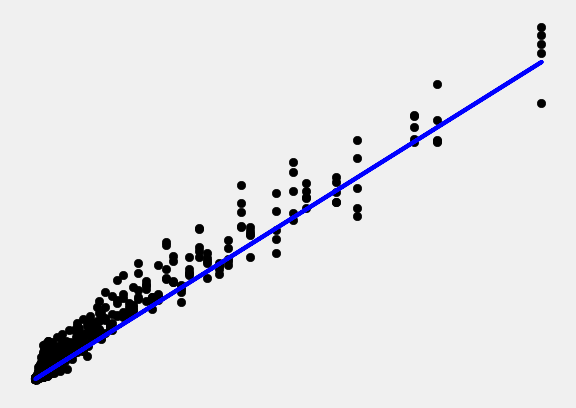

In [37]:
# Plot outputs
plt.scatter(y_test, pred_list, color="black")
plt.plot(y_test, y_test, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

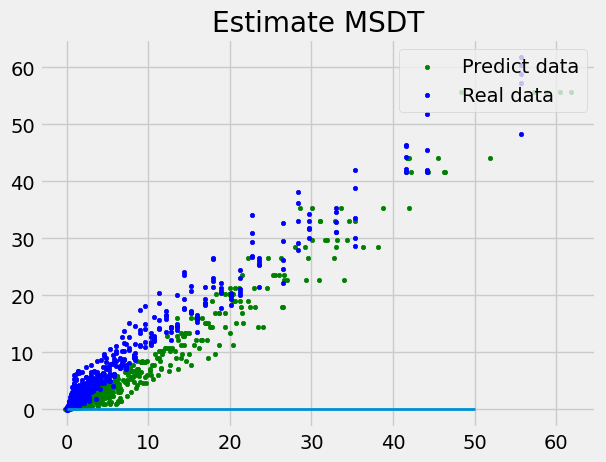

In [31]:
## setting plot style
plt.style.use('fivethirtyeight')
  
## plotting residual errors in training data
plt.scatter(pred_list, y_test,
            color = "green", s = 10, label = 'Predict data')
  
## plotting residual errors in test data
plt.scatter(y_test, pred_list,
            color = "blue", s = 10, label = 'Real data')
  
## plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
  
## plotting legend
plt.legend(loc = 'upper right')
  
## plot title
plt.title("Estimate MSDT")
  
## method call for showing the plot
plt.show()

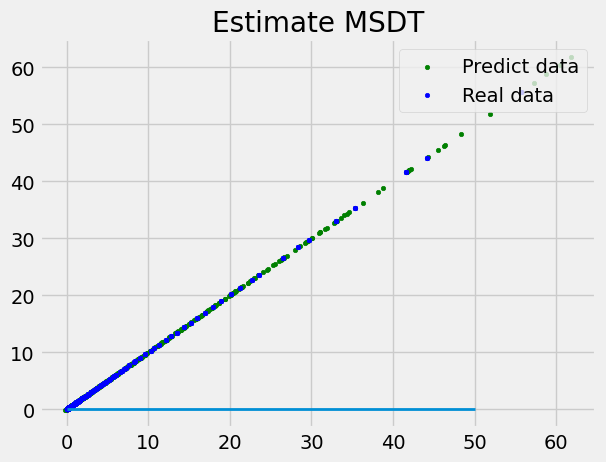

In [33]:
## setting plot style
plt.style.use('fivethirtyeight')
  
## plotting residual errors in training data
plt.scatter(pred_list, pred_list,
            color = "green", s = 10, label = 'Predict data')
  
## plotting residual errors in test data
plt.scatter(y_test, y_test,
            color = "blue", s = 10, label = 'Real data')
  
## plotting line for zero residual error
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 2)
  
## plotting legend
plt.legend(loc = 'upper right')
  
## plot title
plt.title("Estimate MSDT")
  
## method call for showing the plot
plt.show()